# Load features and targets

In [1]:
# load features
import pickle
features = pickle.load( open( "Onehotfeatures.pkl", "rb" ) )

# load associated targets
from numpy import load
y = load('target.npy')

Choose features and prepare data for scikit-learn prototyping

In [2]:
# keep features of interest
imp_feature = ['User_ID', 'Product_ID', 'Gender_Prod_cat123']
# imp_feature = ['User_ID', 'Product_ID', 'Gender', 'Prod_cat123']
# only keep corresponding features
X_features = tuple(f[0] for f in features if f[1] in imp_feature)

In [3]:
from scipy.sparse import hstack
X = hstack( X_features )
X.shape, type(X)

((550068, 9993), scipy.sparse.coo.coo_matrix)

# Stacking Ridge and GBRT

Here we will use Ridge and GBRT to predict purchase. From those two outputs, we will make a blender to give us a single purchase prediction. Using Ridge and GBRT is a good choice because there are making different type of mistakes. Stacking both will yield better performance.

Split training set in two parts (One for training Ridge and GBRT and the other to make prediction that will serve as 'clean' features for our blender)

In [1]:
# split training set in two
from sklearn.model_selection import train_test_split
X_1, X_2, y_1, y_2 = train_test_split(X, y, test_size=0.5, random_state=4)

NameError: name 'X' is not defined

Load Ridge and GRBT models

In [ ]:
from sklearn.externals import joblib
gbrt_stack = joblib.load('GBRT_Model.pkl')
ridge_stack = joblib.load('Ridge_Model.pkl')

Re-train Ridge and GBRT on training data 1st half

In [ ]:
gbrt_stack.fit(X_1, y_1)
ridge_stack.fit(X_1, y_1)

Make predictions on 2nd half

In [185]:
# Ridge and GBRT predictions on 2nd half
gbrt_pred = gbrt_stack.predict(X_2)
ridge_pred = ridge_stack.predict(X_2)
# stack predictions together
import numpy as np
X_blender = np.stack((gbrt_pred, ridge_pred), axis=1)

Parameter grid for grid search

In [186]:
# values for parameter grid
alpha_arr = np.array([ 10**x for x in range(-2,1)])
alpha_arr = np.concatenate([alpha_arr, 3*alpha_arr])
# parameter grid
param_grid_model_blr = [ {'alpha': alpha_arr} ]
param_grid_model_blr

[ 0.01  0.1   1.    0.03  0.3   3.  ]


Create Blender (Ridge) and do a grid search

In [ ]:
# train blender
from sklearn.linear_model import Ridge
model_blr = Ridge( random_state=29, solver='svd')

# polynomial features
# NOTE: no need to do feature scaling since ridge is a closed-form
from sklearn.preprocessing import PolynomialFeatures
polystack = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_blender_poly = polystack.fit_transform(X_blender)

# Grid search on max_depth, min_samples_leaf
from sklearn.model_selection import GridSearchCV, ShuffleSplit
# n_splits is the number of times you split data after shuffling
cv = ShuffleSplit(n_splits=5, test_size=1/5, random_state=4)

# cv could be a fixed number of partitions but there would be no shuffling in that case
# it will just rotate on partitions (k-1) parts and 1 part for cross-val
model_blr_grid = GridSearchCV(model_blr, param_grid_model_blr, cv = cv,\
                              scoring = 'neg_mean_squared_error', n_jobs = -1, verbose = 1)

# run grid search
model_blr_grid.fit( X_blender_poly , y_2 )

Performance result on cross-validation

In [ ]:
# best of mean test score
print( 'MSE, best param, mean cross-val = {:.4f}'.format(-model_blr_grid.best_score_) )
print( 'RMSE, best param, mean cross-val = {:.4f}'.format(np.sqrt(-model_blr_grid.best_score_)) )
print(model_blr_grid.best_estimator_)

Performance on entire training set

In [ ]:
# metrics on entire dataset, must be higher that Xval scores
y_pred = model_blr_grid.predict(X)
from sklearn.metrics import mean_squared_error
print('\nMSE (whole training set) = {:.4f}'.format(mean_squared_error(y, y_pred)))
print('RMSE (whole training set) = {:.4f}'.format(np.sqrt(mean_squared_error(y, y_pred))))

### Are mistakes made by GBRT and Ridge really different?
Spolier alert: yes!

<IPython.core.display.Javascript object>


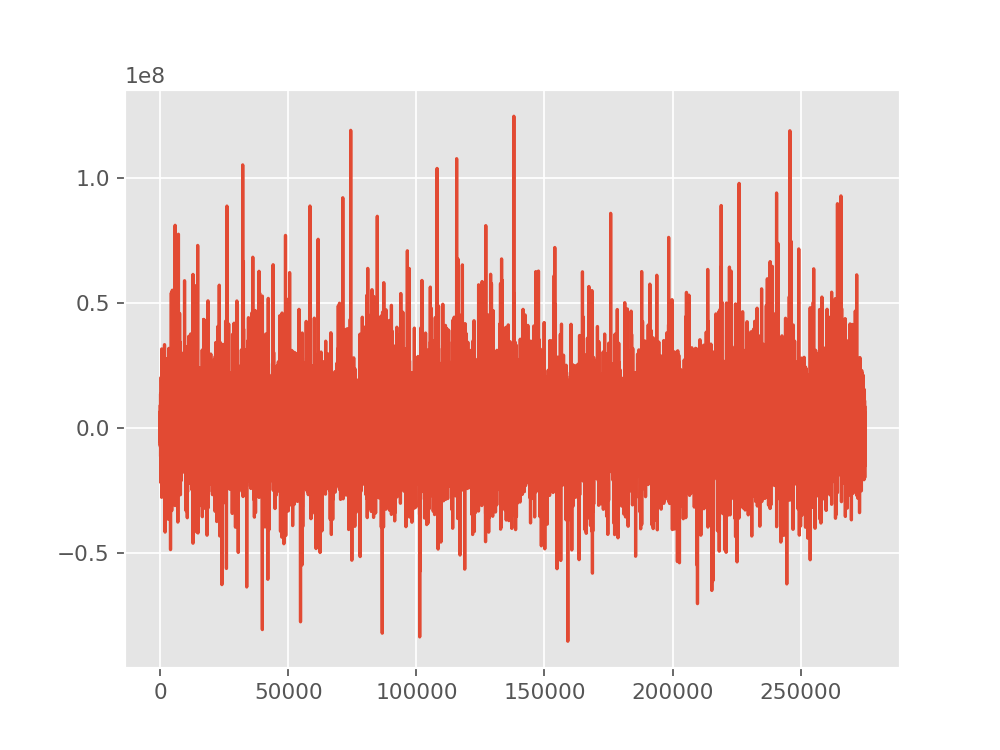

3996639.84649


In [110]:
# keep matplotlib interactive
%matplotlib notebook
import matplotlib.pyplot as plt
# use ggplot style
plt.style.use('ggplot')

# plot errors for gbrt and ridge
_, axsterr = plt.subplots()
stack_error = (gbrt_pred-y_2)**2 - (ridge_pred-y_2)**2
axsterr.plot(stack_error)
# add title and axes labels
axsterr.set_title('Delta MSE GBRT-Ridge')
axsterr.set_xlabel('Error difference (GBRT-Ridge)')
axsterr.set_ylabel('Samples')

print(np.std(stack_error))

In [104]:
# try decision tree blender instead of Ridge

None
